In [1]:
import sys
sys.path.append("../../h2o-py/build/main") # path to h2o build

# Uplift random forest modeling - H2O-3 vs. CausalML

In [2]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split

import h2o
from causalml.metrics import plot_gain, plot_qini, plot_lift
from causalml.metrics import auuc_score
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [3]:
# Data generation
df, feature_cols = make_uplift_classification(n_samples=100000, 
                                              treatment_name=["control", "treatment"],
                                              n_classification_features=10,
                                              n_classification_informative=10)

# Rename features for easy interpretation of visualization
feature_cols_new = ['feature_%s'%(i) for i in range(len(feature_cols))]
rename_dict = {feature_cols[i]:feature_cols_new[i] for i in range(len(feature_cols))}
df = df.rename(columns=rename_dict)
feature_cols = feature_cols_new

print(df.head())

df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

  treatment_group_key  feature_0  feature_1  feature_2  feature_3  feature_4  \
0           treatment  -0.696589  -1.531339   0.598504  -0.442362  -3.368640   
1           treatment  -1.734370  -2.894930   3.653897  -0.844279  -3.343867   
2             control  -0.438270   0.038893   2.287993   1.545793  -3.453372   
3           treatment  -1.502139   1.692400   0.210930   1.052463  -2.866955   
4             control   2.535457   0.329222   0.580543   0.694155  -1.255418   

   feature_5  feature_6  feature_7  feature_8  feature_9  conversion  \
0   0.207879   1.487930  -2.754940  -2.228405   2.049576           0   
1   4.015698   2.660818  -3.401851  -4.275002   3.593160           0   
2   4.346322   3.289635   1.703655  -1.959676   1.735490           0   
3   1.522505   1.157297   2.280189  -2.859386   0.907246           0   
4  -0.079855  -3.113221   0.017193   2.156657   1.439771           0   

   treatment_effect  
0                 0  
1                 0  
2                 0 

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.49838,100000
treatment,0.50194,100000
All,0.50016,200000


In [4]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
df_train.shape, df_test.shape

((160000, 13), (40000, 13))

In [30]:
ntree = 30
max_depth = 10
metric="ChiSquared"
control_name = "control"
treatment_column = "treatment_group_key"
response_column = "conversion"

# CausalML

In [32]:
# Train CausalML uplift tree
causalml_uplift_model = UpliftRandomForestClassifier(
        n_estimators=ntree,
        max_depth=max_depth,
        evaluationFunction=metric,
        control_name=control_name,
        min_samples_leaf=10,
        min_samples_treatment=10,
        normalization=False,
        random_state=42)

causalml_uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_column].values,
                 y=df_train[response_column].values)

#df_test = df_train
causalml_preds = causalml_uplift_model.predict(df_test.values)

In [ ]:
# Plot uplift tree
graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[0].fitted_uplift_tree, feature_cols)
Image(graph.create_png())

# H2O-3

In [11]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 mins 07 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,38 minutes
H2O_cluster_name:,mori
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4.818 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [7]:
ntree = 50
max_depth = 1
metric="KL"

In [33]:
train_h2o = h2o.H2OFrame(df_train)
train_h2o[treatment_column] = train_h2o[treatment_column].asfactor()
train_h2o[response_column] = train_h2o[response_column].asfactor()
h2o_uplift_model = H2OUpliftRandomForestEstimator(
            ntrees=ntree,
            max_depth=max_depth-1,
            treatment_column=treatment_column,
            uplift_metric=metric,
            gainslift_bins=10,
            min_rows=10,
            nbins=1000,
            seed=42,
            sample_rate=0.80,
            auuc_type="gain",
            score_each_iteration=False)
h2o_uplift_model.train(y=response_column, x=feature_cols, training_frame=train_h2o)
h2o_uplift_model

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Model Details
H2OUpliftRandomForestEstimator :  Uplift Distributed Random Forest
Model Key:  UpliftDRF_model_python_1632921499745_147


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,60.0,161054.0,9.0,9.0,9.0,170.0,263.0,209.26666




ModelMetricsBinomialUplift: upliftdrf
** Reported on train data. **

AUUC: 159.8994951854359

Scoring History: 


,,timestamp,duration,number_of_trees,training_auuc
0,,2021-09-29 16:26:02,0.002 sec,0.0,NaN
1,,2021-09-29 16:26:02,0.282 sec,1.0,0.000000
2,,2021-09-29 16:26:02,0.539 sec,2.0,61.813993
3,,2021-09-29 16:26:03,1.547 sec,3.0,54.822735
4,,2021-09-29 16:26:05,2.739 sec,4.0,-18.855449
5,,2021-09-29 16:26:14,11.830 sec,30.0,159.899495


In [34]:
test_h2o = h2o.H2OFrame(df_test)
preds_h2o = h2o_uplift_model.predict(test_h2o)

perf_h2o = h2o_uplift_model.model_performance(test_h2o)
auuc_h2o = perf_h2o.auuc()
print("H2O training metrics AUUC Gain: "+str(auuc_h2o))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf prediction progress: |█████████████████████████████████████████████████| (done) 100%
H2O training metrics AUUC Gain: 174.76637169538043


In [35]:
preds_comp = preds_h2o["uplift_predict"]
preds_comp.names = ["h2o"]
preds_comp["causal"] = h2o.H2OFrame(causalml_preds)
preds_comp["diff"] = abs(preds_comp["h2o"] - preds_comp["causal"])
preds_comp[treatment_column] = h2o.H2OFrame(df_test[treatment_column].values)
preds_comp[response_column] = h2o.H2OFrame(df_test[response_column].values)
preds_comp.summary()
    
min_diff = preds_comp["diff"].min()
max_diff = preds_comp["diff"].max()
mean_diff = preds_comp["diff"].mean(return_frame=False)[0]
print("min: %f max: %f mean: %f" % (min_diff, max_diff, mean_diff))

results = preds_comp.as_data_frame()
results = results[["h2o", "causal", response_column, treatment_column]]
mapping = {'control': 0, 'treatment': 1}
results = results.replace({treatment_column: mapping})


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,h2o,causal,diff,treatment_group_key,conversion
type,real,real,real,enum,int
mins,-0.23291810862720008,-0.11970419999999991,8.605828538676974e-07,,0.0
mean,0.0017377531141279838,-0.017318074656666748,0.02852917162040614,,0.498775
maxs,0.15866687855062384,0.1047653,0.2340438384557642,,1.0
sigma,0.018167816388126003,0.023259579125572603,0.021394285223076657,,0.5000047494711799
zeros,0,0,0,,20049
missing,0,0,0,0,0
0,-0.0037826966804762885,-0.028244666666666696,0.024461969986190407,control,0.0
1,-0.010682347820450862,-0.00042290000000000383,0.010259447820450858,control,0.0
2,-0.025408055788526923,-0.033516233333333256,0.008108177544806333,treatment,0.0


min: 0.000001 max: 0.234044 mean: 0.028529


In [36]:
auuc = auuc_score(results, outcome_col=response_column, treatment_col=treatment_column, normalize=False)
print("H2O AUUC:")
print(auuc["h2o"])
print("CauslML AUUC:")
print(auuc["causal"])
print("Random AUUC:")
print(auuc["Random"])

H2O AUUC:
174.65310125240737
CauslML AUUC:
27.909644020953408
Random AUUC:
119.51089878740537


## Qini

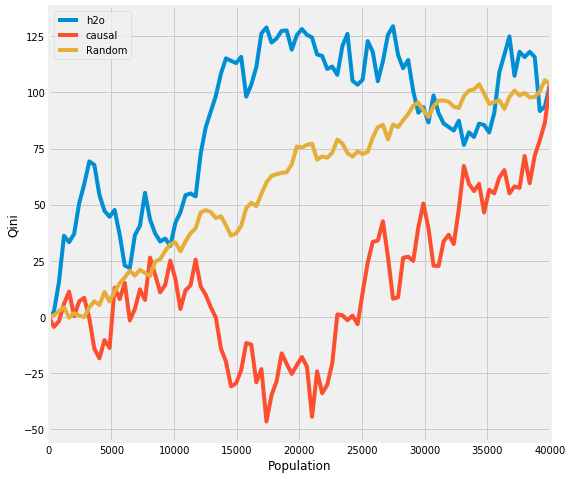

In [37]:
plot_qini(results, outcome_col=response_column, treatment_col=treatment_column)

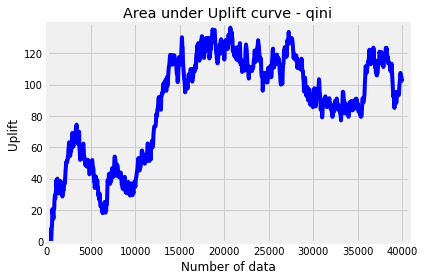

1000
[40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800, 840, 880, 920, 960, 1000, 1040, 1080, 1120, 1160, 1200, 1240, 1280, 1320, 1360, 1400, 1440, 1480, 1520, 1560, 1600, 1640, 1680, 1720, 1760, 1800, 1840, 1880, 1920, 1960, 2000, 2040, 2080, 2120, 2160, 2200, 2240, 2280, 2320, 2360, 2400, 2440, 2480, 2520, 2560, 2600, 2640, 2680, 2720, 2760, 2800, 2840, 2880, 2920, 2960, 3000, 3040, 3080, 3120, 3160, 3200, 3240, 3280, 3320, 3360, 3400, 3440, 3480, 3520, 3560, 3600, 3640, 3680, 3720, 3760, 3800, 3840, 3880, 3920, 3960, 4000, 4040, 4080, 4120, 4160, 4200, 4240, 4280, 4320, 4360, 4400, 4440, 4480, 4520, 4560, 4600, 4640, 4680, 4720, 4760, 4800, 4840, 4880, 4920, 4960, 5000, 5040, 5080, 5120, 5160, 5200, 5240, 5280, 5320, 5360, 5400, 5440, 5480, 5520, 5560, 5600, 5640, 5680, 5720, 5760, 5800, 5840, 5880, 5920, 5960, 6000, 6040, 6080, 6120, 6160, 6200, 6240, 6280, 6320, 6360, 6400, 6440, 6480, 6520, 6560, 6600, 6640, 6680, 6720, 6760, 6800, 

In [38]:
perf_h2o.plot_auuc(metric="qini")

n, uplift = perf_h2o.plot_auuc(metric="qini", plot=False)
print(len(n))
print(n)
print(uplift)

## Lift

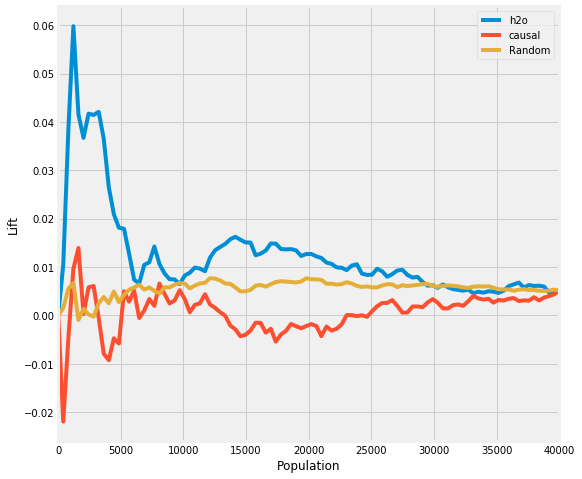

In [39]:
plot_lift(results, outcome_col=response_column, treatment_col=treatment_column)

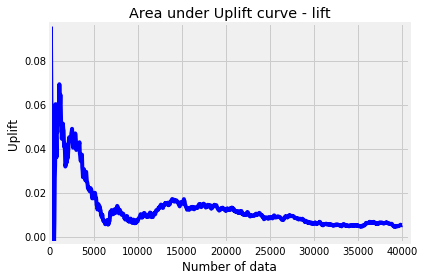

[40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800, 840, 880, 920, 960, 1000, 1040, 1080, 1120, 1160, 1200, 1240, 1280, 1320, 1360, 1400, 1440, 1480, 1520, 1560, 1600, 1640, 1680, 1720, 1760, 1800, 1840, 1880, 1920, 1960, 2000, 2040, 2080, 2120, 2160, 2200, 2240, 2280, 2320, 2360, 2400, 2440, 2480, 2520, 2560, 2600, 2640, 2680, 2720, 2760, 2800, 2840, 2880, 2920, 2960, 3000, 3040, 3080, 3120, 3160, 3200, 3240, 3280, 3320, 3360, 3400, 3440, 3480, 3520, 3560, 3600, 3640, 3680, 3720, 3760, 3800, 3840, 3880, 3920, 3960, 4000, 4040, 4080, 4120, 4160, 4200, 4240, 4280, 4320, 4360, 4400, 4440, 4480, 4520, 4560, 4600, 4640, 4680, 4720, 4760, 4800, 4840, 4880, 4920, 4960, 5000, 5040, 5080, 5120, 5160, 5200, 5240, 5280, 5320, 5360, 5400, 5440, 5480, 5520, 5560, 5600, 5640, 5680, 5720, 5760, 5800, 5840, 5880, 5920, 5960, 6000, 6040, 6080, 6120, 6160, 6200, 6240, 6280, 6320, 6360, 6400, 6440, 6480, 6520, 6560, 6600, 6640, 6680, 6720, 6760, 6800, 6840,

In [40]:
perf_h2o.plot_auuc(metric="lift")

n, uplift = perf_h2o.plot_auuc(metric="lift", plot=False)
print(n)
print(uplift)

## Gain

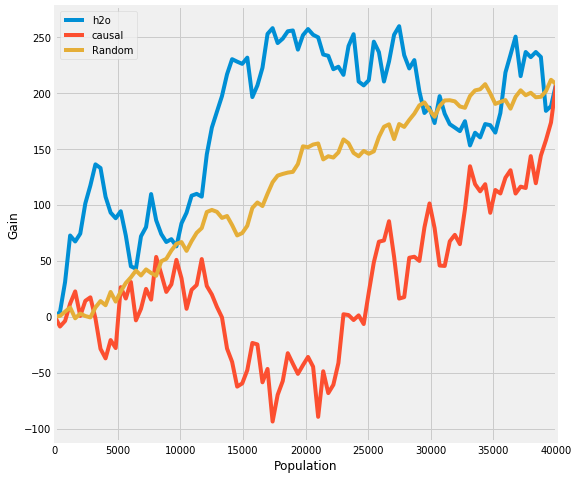

In [41]:
plot_gain(results, outcome_col=response_column, treatment_col=treatment_column)

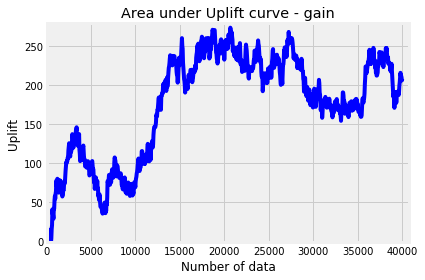

[40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 680, 720, 760, 800, 840, 880, 920, 960, 1000, 1040, 1080, 1120, 1160, 1200, 1240, 1280, 1320, 1360, 1400, 1440, 1480, 1520, 1560, 1600, 1640, 1680, 1720, 1760, 1800, 1840, 1880, 1920, 1960, 2000, 2040, 2080, 2120, 2160, 2200, 2240, 2280, 2320, 2360, 2400, 2440, 2480, 2520, 2560, 2600, 2640, 2680, 2720, 2760, 2800, 2840, 2880, 2920, 2960, 3000, 3040, 3080, 3120, 3160, 3200, 3240, 3280, 3320, 3360, 3400, 3440, 3480, 3520, 3560, 3600, 3640, 3680, 3720, 3760, 3800, 3840, 3880, 3920, 3960, 4000, 4040, 4080, 4120, 4160, 4200, 4240, 4280, 4320, 4360, 4400, 4440, 4480, 4520, 4560, 4600, 4640, 4680, 4720, 4760, 4800, 4840, 4880, 4920, 4960, 5000, 5040, 5080, 5120, 5160, 5200, 5240, 5280, 5320, 5360, 5400, 5440, 5480, 5520, 5560, 5600, 5640, 5680, 5720, 5760, 5800, 5840, 5880, 5920, 5960, 6000, 6040, 6080, 6120, 6160, 6200, 6240, 6280, 6320, 6360, 6400, 6440, 6480, 6520, 6560, 6600, 6640, 6680, 6720, 6760, 6800, 6840,

In [42]:
perf_h2o.plot_auuc(metric="gain")

n, uplift = perf_h2o.plot_auuc(metric="gain", plot=False)
print(n)
print(uplift)